### Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from random import random, seed
import matplotlib.pyplot as plt
import numpy as np
import autograd.numpy as np
from autograd import grad, elementwise_grad
import scikitplot as skplt
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.exceptions import ConvergenceWarning

### Make design matrices from breast cancer data

In [6]:
cancer = load_breast_cancer()

#Splitting data 4/5 train and 1/5 test, so more data to train than test
X, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,test_size=0.2,random_state=0)

scaler = MinMaxScaler()
scaler.fit(X)
X= scaler.transform(X)
X_test = scaler.transform(X_test)
y = y_train.reshape(-1,1) # (455,1)

print(y.shape)
print(X.shape)
print(X_test.shape)

n = X.shape[0] # 455

# Hessian matrix
H = (2.0/n)* X.T @ X
# Get the eigenvalues
EigValues, EigVectors = np.linalg.eig(H)
# print(f"Eigenvalues of Hessian Matrix:{EigValues}")

beta_start = np.random.randn(X.shape[1], 1)
Niterations = 1000

(455, 1)
(455, 30)
(114, 30)


### Setting up the plots variables

In [7]:
xnew = X_test
x = np.arange(len(y_test))

### RMSProp Gradient Descent

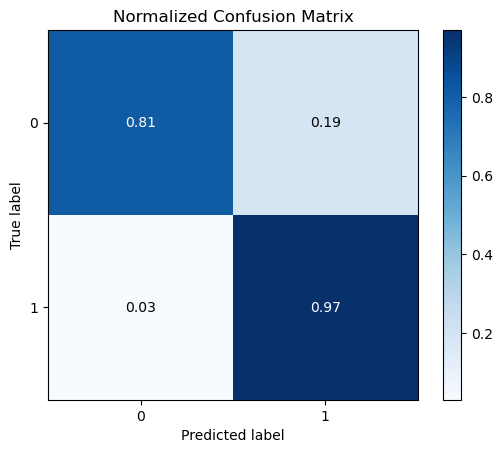

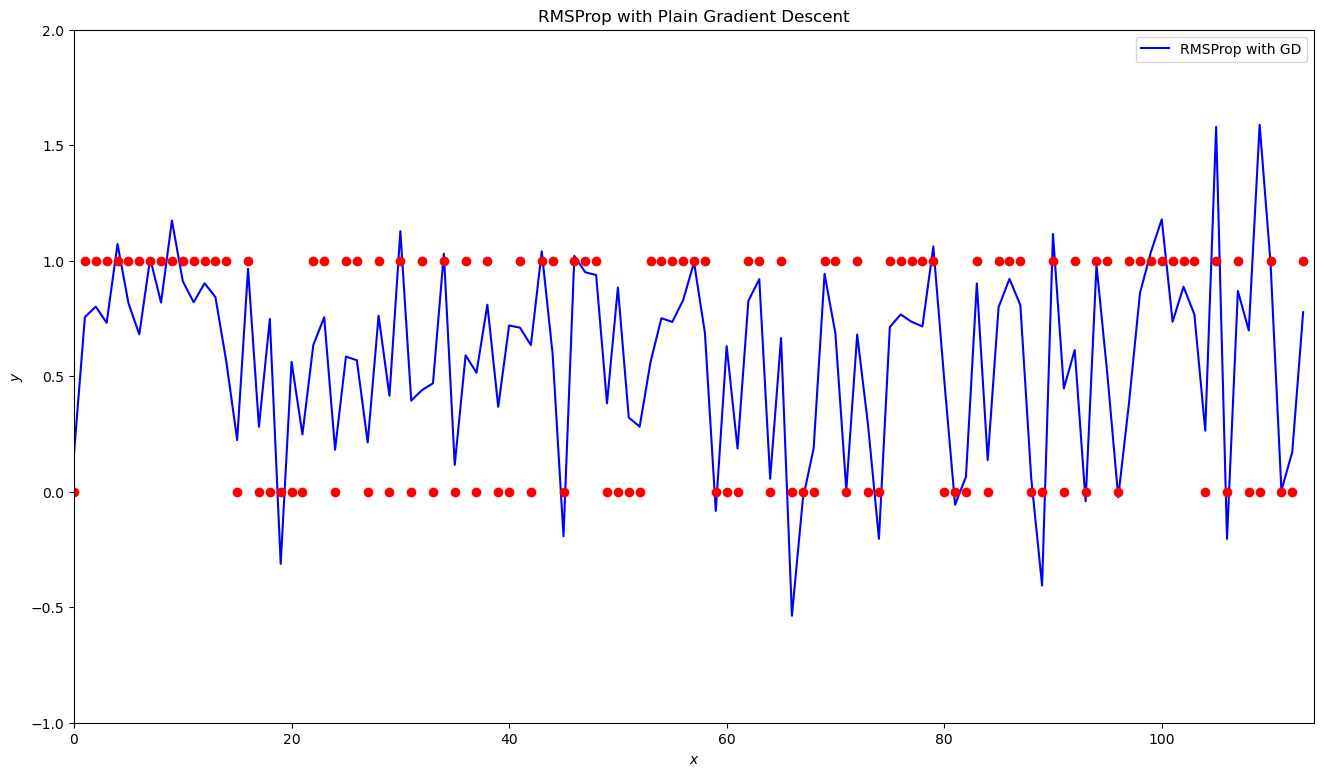

In [8]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def CostOLS(beta):
    return (1.0/n)*np.sum((y-X @ beta)**2)

def CostOLS_momentum(y,X,theta):
    return np.sum((y-X @ theta)**2)

# Guess for unknown parameters beta
beta = beta_start
training_gradient = grad(CostOLS)

# Value for learning rate
eta = 0.01
# Value for parameter rho
rho = 0.99
# Including AdaGrad parameter to avoid possible division by zero
delta  = 1e-7
Giter = 0.0

for iter in range(Niterations):
    gradients = training_gradient(beta)
    # Accumulated gradient
    # Scaling with rho the new and the previous results
    Giter = (rho*Giter+(1-rho)*gradients*gradients)
    # Taking the diagonal only and inverting
    update = gradients*eta/(delta+np.sqrt(Giter))
    # Hadamard product
    beta -= update

ypredict_rmsprop_gd = xnew.dot(beta)

ypredict_rmsprop_gd_binary = [1 if x >= 0.5 else 0 for x in ypredict_rmsprop_gd]
skplt.metrics.plot_confusion_matrix(y_test, ypredict_rmsprop_gd_binary, normalize=True)
plt.show()

plt.figure(figsize=(16,9))
plt.plot(x, ypredict_rmsprop_gd, "b-", label = "RMSProp with GD")
plt.plot(x, y_test ,'ro')
# plt.plot(x, ypredict_rmsprop_gd_binary, "go", label = "RMSProp with GD (binary response)")
plt.axis([0,len(X_test),-1,2])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'RMSProp with Plain Gradient Descent')
plt.legend()
plt.show()

### RMSProp Gradient Descent with Momentum

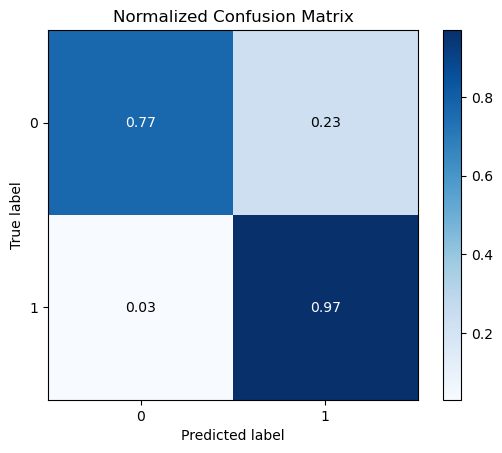

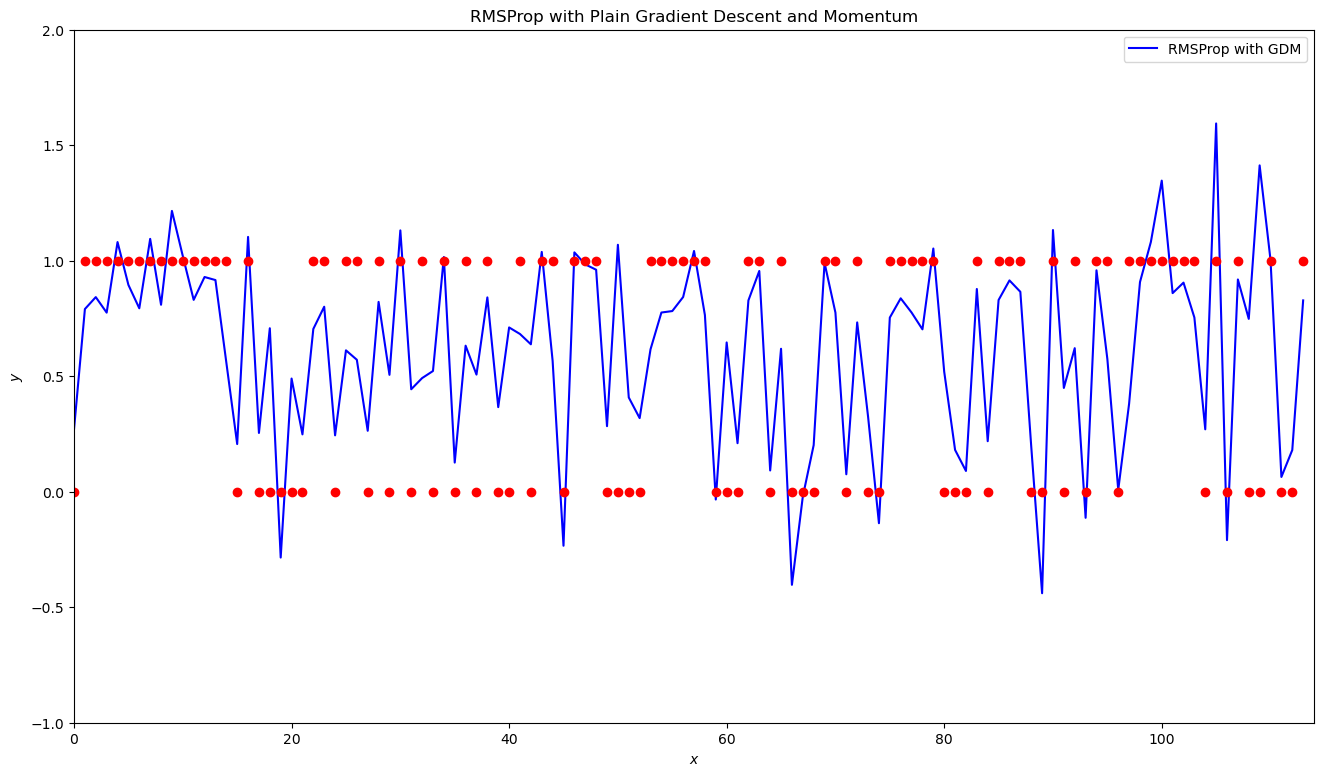

In [9]:
# Guess for unknown parameters beta
beta = beta_start
training_gradient = grad(CostOLS)

# Value for learning rate
eta = 0.01
# Value for parameter rho
rho = 0.99
# Including AdaGrad parameter to avoid possible division by zero
delta  = 1e-7
# Now improve with momentum gradient descent
change = 0.0
delta_momentum = 0.3
Giter = 0.0

for iter in range(Niterations):
    gradients = training_gradient(beta)
    # Accumulated gradient
    # Scaling with rho the new and the previous results
    Giter = (rho*Giter+(1-rho)*gradients*gradients)
    # Taking the diagonal only and inverting
    update = gradients*eta/(delta+np.sqrt(Giter))+delta_momentum*change
    # Hadamard product
    beta -= update
    # Save the change
    change = update

ypredict_rmsprop_gdm = xnew.dot(beta)

ypredict_rmsprop_gdm_binary = [1 if x >= 0.5 else 0 for x in ypredict_rmsprop_gdm]
skplt.metrics.plot_confusion_matrix(y_test, ypredict_rmsprop_gdm_binary, normalize=True)
plt.show()

plt.figure(figsize=(16,9))
plt.plot(x, ypredict_rmsprop_gdm, "b-", label = "RMSProp with GDM")
plt.plot(x, y_test ,'ro')
# plt.plot(x, ypredict_rmsprop_gdm_binary, "go", label = "RMSProp with GDM (binary response)")
plt.axis([0,len(X_test),-1,2])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'RMSProp with Plain Gradient Descent and Momentum')
plt.legend()
plt.show()

### Setting up the Stochastic variables

In [10]:
# Define parameters for Stochastic methods
n_epochs = 50
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
t0, t1 = 5, 50

def learning_schedule(t):
    return t0/(t+t1)

### RMSProp Stochastic Gradient Descent

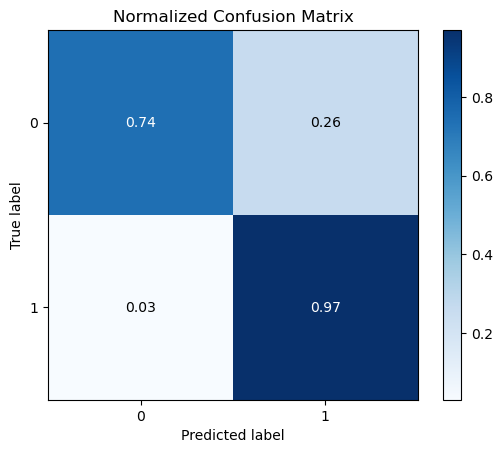

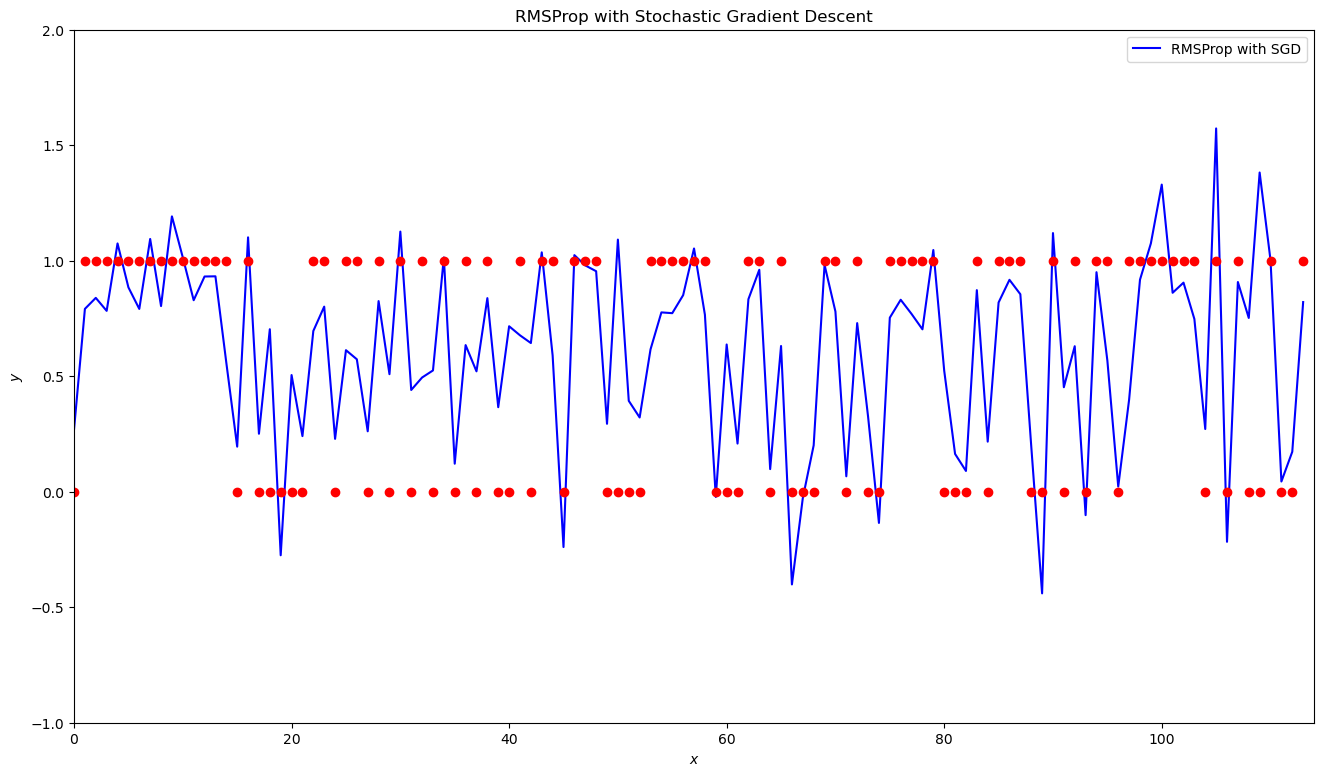

In [11]:
# Guess for unknown parameters beta
beta = beta_start
training_gradient = grad(CostOLS_momentum,2)

# Value for learning rate
eta = 0.01
# Value for parameter rho
rho = 0.99
# Including AdaGrad parameter to avoid possible division by zero
delta  = 1e-7
Giter = 0.0
# Now improve with momentum gradient descent
change = 0.0
delta_momentum = 0.3

for epoch in range(n_epochs):
    # Notations in book
    Giter = 0.0 # r
    for i in range(m):
        random_index = M*np.random.randint(m) # Sample of mini batchs
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        gradients = (1.0/M)*training_gradient(yi,xi,beta) # g
        Giter += gradients*gradients 
        eta = learning_schedule(epoch*m+i)
        update = gradients*eta/(delta+np.sqrt(Giter)) # update
        beta -= update

ypredict_rmsprop_sgd = xnew.dot(beta)

ypredict_rmsprop_sgd_binary = [1 if x >= 0.5 else 0 for x in ypredict_rmsprop_sgd]
skplt.metrics.plot_confusion_matrix(y_test, ypredict_rmsprop_sgd_binary, normalize=True)
plt.show()

plt.figure(figsize=(16,9))
plt.plot(x, ypredict_rmsprop_sgd, "b-", label = "RMSProp with SGD")
plt.plot(x, y_test ,'ro')
# plt.plot(x, ypredict_rmsprop_sgd_binary, "go", label = "RMSProp with SGD (binary response)")
plt.axis([0,len(X_test),-1,2])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'RMSProp with Stochastic Gradient Descent')
plt.legend()
plt.show()

### RMSProp Stochastic Gradient Descent with Momentum

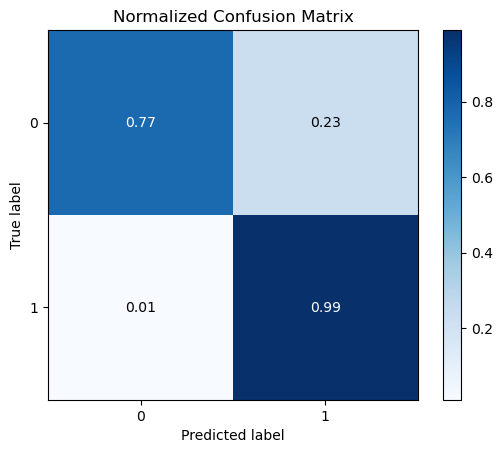

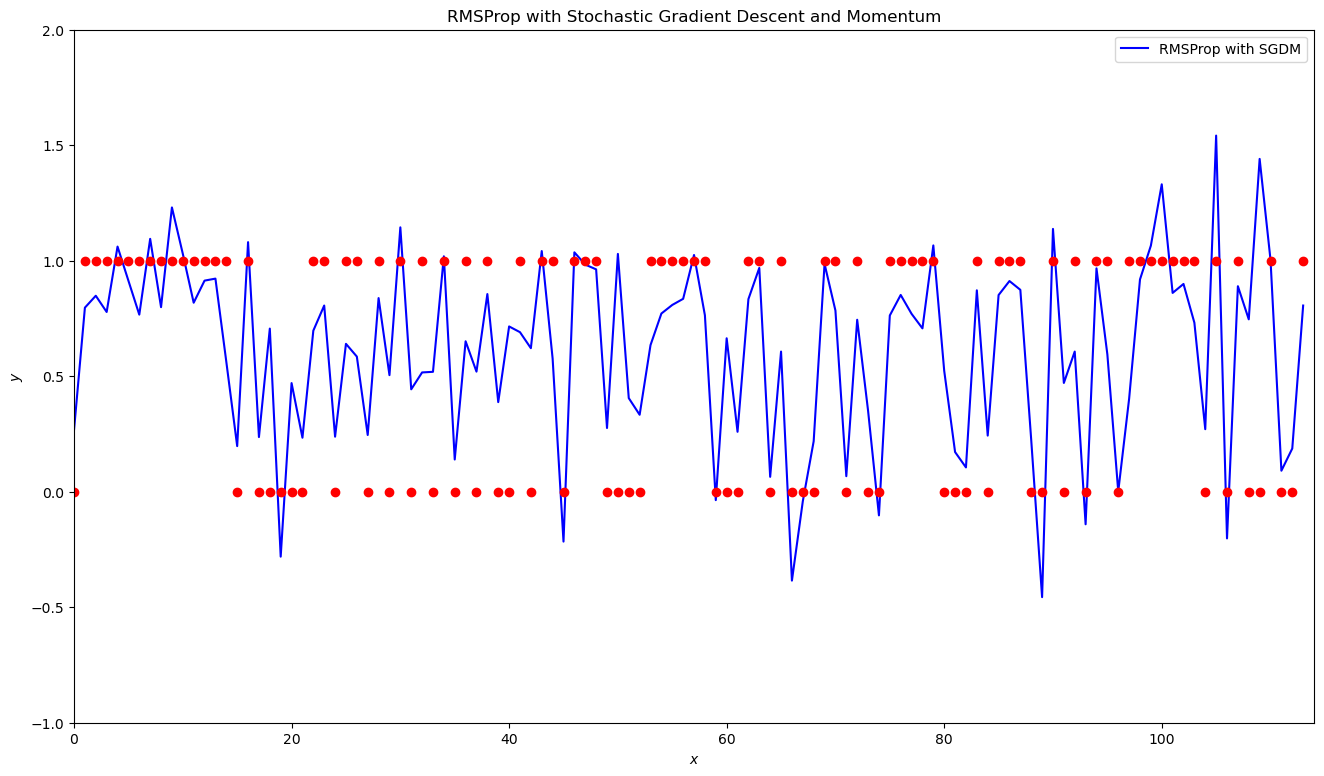

In [12]:
# Guess for unknown parameters beta
beta = beta_start
training_gradient = grad(CostOLS_momentum,2)

# Value for learning rate
eta = 0.01
# Value for parameter rho
rho = 0.99
# Including AdaGrad parameter to avoid possible division by zero
delta  = 1e-7
Giter = 0.0
# Now improve with momentum gradient descent
change = 0.0
delta_momentum = 0.3
# Now improve with momentum gradient descent
change = 0.0
delta_momentum = 0.3

for epoch in range(n_epochs):
    # Notations in book
    Giter = 0.0 # r
    for i in range(m):
        random_index = M*np.random.randint(m) # Sample of mini batchs
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        gradients = (1.0/M)*training_gradient(yi,xi,beta) # g
        Giter += gradients*gradients 
        eta = learning_schedule(epoch*m+i)
        update = gradients*eta/(delta+np.sqrt(Giter)) + delta_momentum*change # update
        # Take a step
        beta -= update
        # Save the change
        change = update

ypredict_rmsprop_sgdm = xnew.dot(beta)

ypredict_rmsprop_sgdm_binary = [1 if x >= 0.5 else 0 for x in ypredict_rmsprop_sgdm]
skplt.metrics.plot_confusion_matrix(y_test, ypredict_rmsprop_sgdm_binary, normalize=True)
plt.show()

plt.figure(figsize=(16,9))
plt.plot(x, ypredict_rmsprop_sgdm, "b-", label = "RMSProp with SGDM")
plt.plot(x, y_test ,'ro')
# plt.plot(x, ypredict_rmsprop_sgdm_binary, "go", label = "RMSProp with SGDM (binary response)")
plt.axis([0,len(X_test),-1,2])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'RMSProp with Stochastic Gradient Descent and Momentum')
plt.legend()
plt.show()